In [1]:
import pandas as pd
import numpy as np
import pickle
from itertools import chain
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
import csv
import os
import string
import textblob
import io

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import preprocessing
from sklearn import decomposition, ensemble

from importlib import reload
# reload(text_processing)


# nlp = spacy.load('en') # loading the language model 
#data = pd.read_feather('data/preprocessed_data') # reading a pandas dataframe which is stored as a feather file


%matplotlib inline
# sns.set_context('poster')
# sns.set_color_codes()
full_path_data_store = '/home/silas/final_project/Data/'

/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/silas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data
- load data from file
- eda/inspect data
- assemble datasets for parity
- merge with climate data

#### load data

In [2]:
def load_all_data(data_list,full_path_data_store=full_path_data_store):
    '''
    Args: 
    - data_list: list of dataframes to load
    - full_path_data_store: path to data
    Returns:
    Dictionary of dataframes by name
    '''
    df_datasets={}
    for df_name in data_list:
        print('loading {} data...'.format(df_name))
        df = pd.read_pickle(full_path_data_store + "{}.pkl".format(df_name)).drop_duplicates(subset='processed_text')
        df.name = df_name
        
        # clean climate docs of headers and footers
        if df_name == 'climate':
            df['processed_text']=[i[515:-700].split(' ',2)[2].rsplit(' ',1)[0] for i in df.processed_text]
            df.name = df_name
        df_datasets[df_name]=df
    
    return df_datasets

In [3]:
data_list=['climate', 'spam', 'newsgroups', 'reuters', 'bbc', 'science']

In [4]:
# load all data
df_datasets=load_all_data(data_list)

loading climate data...
loading spam data...
loading newsgroups data...
loading reuters data...
loading bbc data...
loading science data...


#### eda

In [5]:
def get_doc_counts(df):
    """
    Args:
        df: a data frame
    Returns:
        a list of length counts for each doc
    """
    
    return [len(i) for i in df.processed_text] 

In [6]:
def count_zero_lens(df):
    """
    Args:
        df: a data frame
    Returns:
        a list of zero counts for each doc 
    """
    
    count=0
    for i in df.processed_text:
        if len(i) == 0:
            count+=1
    return count

In [7]:
def get_df_stats(df_dict, record_=True, print_=True):
    
    """
    Args:
        df_dict: dict of dataframe objects
    Returns:
    - Option: 'print_' boolean, returns a dataframe of stats for data 
    - Option: 'record_' boolean, saves stats to csv
    """
    
    columns=['total_docs','dups','zero_vals','vocab_raw','vocab_proc','min_doc_len','max_doc_len','mean_len','std']
    temp_dict={}
    for k,v in df_dict.items():
        row=[]
        cv = CountVectorizer()
        cvu = CountVectorizer()
        cvu.fit(v.processed_text)
        cv.fit(v.texts)
        vdc = get_doc_counts(v)
        row.append([
                    len(vdc),
                   len(v.processed_text)-len(v.processed_text.unique()),
                   count_zero_lens(v),
                   len(cv.vocabulary_),
                   len(cvu.vocabulary_),
                   min(vdc),
                    max(vdc),
                   int(np.mean(vdc)),
                   int(np.std(vdc))
                   ])
        temp_dict[k]=row[0]
    
    df=pd.DataFrame(temp_dict).T
    df.columns=columns
    
    if record_:
        df.reset_index(drop=True)
        time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
        df.to_csv('Output/DF_analysis/df_stats_{}.csv'.format(time_))
    
    if print_:
        return df
    return df

In [8]:
def plot_classes(df_dict):
    """
    Plots histogram of classes in dataset 
    
    Args:
        df_dict: dict of dataframes
    returns:
        None
    """
    
    time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
    encoder = preprocessing.LabelEncoder()
    result_dict={}
    classes={}
    for k,v in df_dict.items():
        result_dict[k] = v.labels.value_counts()
        classes[k]= np.unique(encoder.fit_transform(v.labels))
    fig, axs = plt.subplots(1, len(result_dict), figsize=(15, 2), sharey=True,sharex=False)
    fig.suptitle('Distribution of Unique Classes (chars)')
    for idx,kv in enumerate(result_dict.items()):
        axs[idx].bar(classes[kv[0]],height=kv[1])
        axs[idx].set_xlabel(kv[0])
    plt.savefig('Output/DF_analysis/all_dfs_classes_histograms_{}.png'.format(time_))

In [9]:
import matplotlib.pyplot as plt
% matplotlib inline
# slice docs in climate data to get meat
# make mask based on min/max length of merged dataset 

def plot_doc_lengths(df_dict):
    """
    Plots histogram of length of docs in dataset
    
    Args:
        df_dict
    Return:
        None
    """
    
    result_dict={}
    for k,v in df_dict.items():
        result_dict[k] = get_doc_counts(v)
    fig, axs = plt.subplots(1, len(result_dict), figsize=(15, 2), sharey=False,sharex=False)
    fig.suptitle('Distribution of Document Lengths (chars)')
    for idx,kv in enumerate(result_dict.items()):
        axs[idx].hist(kv[1])
        #axs[1,idx].boxplot(kv[1].get('count'))
        axs[idx].set_xlabel(kv[0])
    time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
    plt.savefig('Output/DF_analysis/all_dfs_distributions_{}.png'.format(time_))

In [10]:
get_df_stats(df_datasets)

,total_docs,dups,zero_vals,vocab_raw,vocab_proc,min_doc_len,max_doc_len,mean_len,std
climate,6126,3,0,22486,12648,2,7480,1007,655
spam,4889,0,1,8633,5782,0,361,35,27
newsgroups,10711,0,0,98439,55269,56,40834,873,1723
reuters,10530,0,1,30913,21761,0,5610,474,505
bbc,2114,0,1,29418,21626,0,12948,1290,731
science,5735,0,0,42109,29684,47,2649,922,302


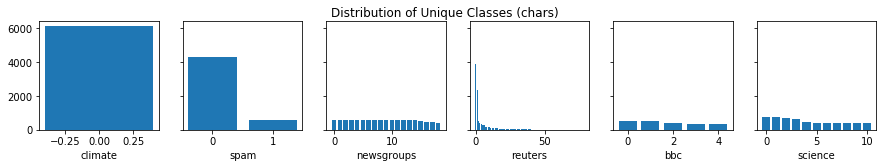

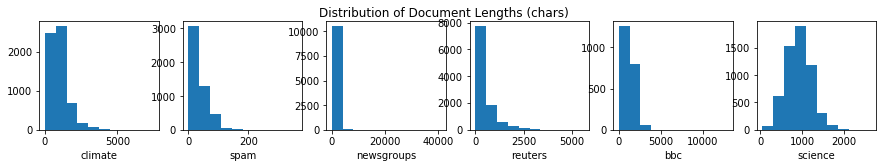

In [11]:
plot_classes(df_datasets)
plot_doc_lengths(df_datasets)

#### clip doc lengths

In [12]:
def clip_doc_lengths(df_dict,max_len=10000,min_len=100):
    """
    Args:
        df_dict: dict dataframe object
        max_len: sets maximum length for doc
        min_len: sets minimum length for doc
    Returns:
        dict dataframe object
    """
    for df_name,df in df_dict.items():
        
        if df_name != 'spam':
            df_name=df.name
            df['len_counts']=get_doc_counts(df)
            mean_=df['len_counts'].mean()
            df=df[(df.len_counts<=max_len)&(df.len_counts>=min_len)]
            df=df.drop(['len_counts'],axis=1)
        df.name=df_name
        df_dict[df_name]=df
    return df_dict

In [13]:
df_datasets_clipped=clip_doc_lengths(df_datasets)    

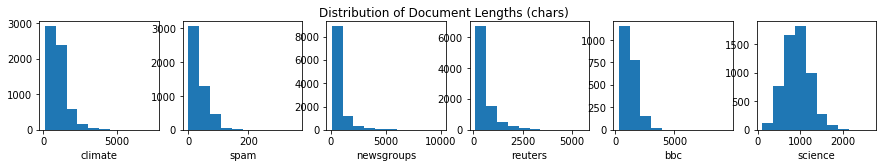

In [14]:
plot_doc_lengths(df_datasets_clipped)

In [15]:
get_df_stats(df_datasets_clipped)

,total_docs,dups,zero_vals,vocab_raw,vocab_proc,min_doc_len,max_doc_len,mean_len,std
climate,6113,3,0,22486,12647,100,7480,1009,654
spam,4889,0,1,8633,5782,0,361,35,27
newsgroups,10612,0,0,91637,50824,100,9985,768,847
reuters,9112,0,0,30103,21423,100,5610,537,516
bbc,2112,0,0,29342,21576,283,9478,1285,685
science,5733,0,0,42109,29684,109,2649,922,302


#### remove over-represented words

In [16]:
def get_top_word_freqs(df_dict,n=10):
    time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
    temp_dict={}
    for k,v in df_dict.items():
        temp_dict[k]=v.processed_text.str.split(expand=True).stack().value_counts().head(10)
    df=pd.DataFrame(temp_dict)
    df.to_csv("Output/DF_analysis/top_word_frequencies_{}.csv".format(time_))
    return df

In [17]:
df_word_freqs=get_top_word_freqs(df_datasets_clipped)
df_word_freqs

,climate,spam,newsgroups,reuters,bbc,science
agency,6250.0,NaN,NaN,NaN,NaN,NaN
analysis,NaN,NaN,NaN,NaN,NaN,2612.0
article,NaN,NaN,7247.0,NaN,NaN,NaN
billion,NaN,NaN,NaN,5651.0,NaN,NaN
cell,NaN,NaN,NaN,NaN,NaN,5221.0
come,NaN,291.0,NaN,NaN,1140.0,NaN
company,NaN,NaN,NaN,5456.0,NaN,NaN
control,NaN,NaN,NaN,NaN,NaN,2988.0
ct,NaN,NaN,NaN,5599.0,NaN,NaN
date,6594.0,NaN,NaN,NaN,NaN,NaN


In [18]:
def get_freq_words(df_dict, n=15,cut_n=5, plot_=True):
    
    """
    Args
        df_dict: dict of dataframes
        n: number of most frequent words to select from dataframe
        plot_: boolean, show plot of results
    Return
        dictionary of most frequent words for each dataframe 
    """
    
    fig, axs = plt.subplots(1, len(df_dict), figsize=(15, 2), sharey=False,sharex=False)
    fig.suptitle('{} Frequent Words by Dataset'.format(n))
    
    words_cut={}
    for i,kv in enumerate(df_dict.items()):
        
        idx = kv[1].processed_text.str.split(expand=True).stack().value_counts().index
        vals = kv[1].processed_text.str.split(expand=True).stack().value_counts()
        df = pd.DataFrame({'idx':idx, 'vals':vals})
    
        if plot_:
            sns.set_palette("Paired")
            g=sns.barplot(x="idx", y="vals", data=df.head(15),ax=axs[i]).set_xticklabels(labels=df.idx,rotation=75)
            axs[i].set_xlabel(kv[0])
            time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
            plt.savefig('Output/DF_analysis/distribution_of_{}_frequent_words_{}.png'.format(n,time_))
        
        words_cut[kv[0]]=list(df.head(cut_n).idx)
        
    return words_cut

In [19]:
def remove_freq_words(df_dict,freq_list):
    """
    Arg
        df_dict: a dict of dataframes
        freq_list: dict of lists, keys are df_names
    Return
        dict of dataframes
    """
    
    for df_name,word_lst in freq_list.items():
        for word in word_lst:
            df_dict[df_name].processed_text=df_dict[df_name].processed_text.str.replace(word+" ","")
    return df_dict

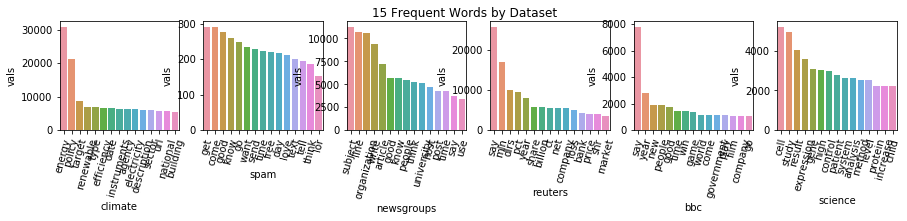

In [20]:
# get frequent words
freq_words=get_freq_words(df_datasets_clipped)

In [21]:
# remove frequent words
df_datasets=remove_freq_words(df_datasets_clipped,freq_words)

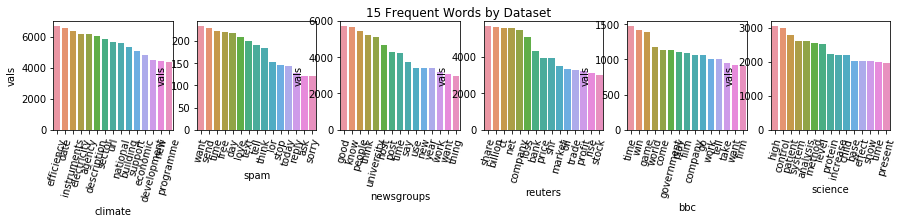

In [22]:
# display results
freq_words_=get_freq_words(df_datasets_clipped)

#### merge climate with other data for testing

In [25]:
df_data={}
df_data['climate']=df_datasets['climate']
df_data['science']=df_datasets['science']
get_df_stats(df_data)

,total_docs,dups,zero_vals,vocab_raw,vocab_proc,min_doc_len,max_doc_len,mean_len,std
climate,6113,6,0,22486,12745,60,7163,922,612
science,5733,0,0,42109,29904,109,2586,897,292


In [26]:
def merge_df(target_df,other_df,name_of_new_df):
    '''
    Args: 
    - target_df: 'climate'
    - df_other: a pd.dataframe with columns: 'texts','labels','processed_text'
    name_of_new-df: a string
    Returns: 
    - a dataframe with climate and random sample of other data 50/50 split,
        '1' = 'climate' '2' = 'other label'
    Note: uncomment other labels
    '''
    
    df = target_df
    length = min(df.shape[0],other_df.shape[0])
    other_s = other_df.sample(length)
    other_s.labels = 0
    df_s = df.sample(length)
    df_os = other_s.append(df_s,sort=False)
    df_os.name=name_of_new_df
    time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
    df_os.to_pickle(full_path_data_store + "{}_merged.pkl".format(name_of_new_df))
    
    return df_os

In [27]:
# merge climate with other dataset and add to dataframe dict

def merge_to_data_dict(name_primary_df, name_other_df,name_mgd_df):
    """
    Merges and adds dataframe to data dict
    Args
        name_primary_df name of first df
        name_other_df: name of second df
        name_mgd_df: name of merged df
    Return
        None
    """
    df_datasets[name_mgd_df]=merge_df(df_datasets[name_primary_df],df_datasets[name_other_df],name_mgd_df)

    
merge_to_data_dict('climate','science','climate_science_merged')
get_df_stats(df_datasets).loc[['climate_science_merged'],:]

,total_docs,dups,zero_vals,vocab_raw,vocab_proc,min_doc_len,max_doc_len,mean_len,std
climate_science_merged,11466,4,0,54469,36636,60,7163,912,481


In [24]:
with open(full_path_data_store+'df_datasets.pickle', 'wb') as handle:
    pickle.dump(df_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)